# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
count = {'missing_unknown': 0}

for (columnName, columnData) in azdias.iteritems():
    
    count['missing_unknown'] += np.sum(columnData==0)
    count['missing_unknown'] += np.sum(columnData==-1)
    count['missing_unknown'] += np.sum(columnData==9)
    count['missing_unknown'] += np.sum(columnData.values=='X')
    count['missing_unknown'] += np.sum(columnData.values=='XX')
    
print('Total Number of missing/unknown Values: ', count['missing_unknown'])
    

C:\Users\obinna\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':
C:\Users\obinna\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


Total Number of missing/unknown Values:  9983183


In [8]:
for idx in range(feat_info.shape[0]):
    replaced = 0
    missing_or_unknown = feat_info.iloc[idx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[]')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(i) if (i!='X' and i!='XX' and i!='') else i for i in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias.iloc[:,idx] = azdias.iloc[:,idx].replace(missing_or_unknown, np.nan)

In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
proportion_missing_per_col = azdias.isnull().sum()/azdias.shape[0]

In [12]:
proportion_missing_per_col

AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GEBURTSJAHR              0.440203
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
RETOURTYP_BK_S           0.005446
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST    

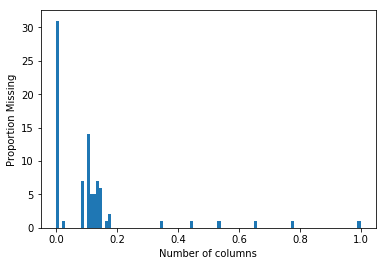

In [13]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(proportion_missing_per_col, bins=100)
plt.xlabel('Number of columns')
plt.ylabel('Proportion Missing')
plt.show()

In [14]:
#filter out columns with 25% or more missing values
proportion_missing_per_col_25 = proportion_missing_per_col[proportion_missing_per_col>0.25] 

In [15]:
proportion_missing_per_col_25

AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
ALTER_HH        0.348137
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64

In [16]:
#distribute our data into groups according to percentage of missing values
missing_proportion = {'0-20':0, '21-40':0, '41-60':0, '61-80':0, '81-100':0}

for k, v in dict(proportion_missing_per_col).items():
    if v <= 0.20:
        missing_proportion['0-20'] += 1
    if v > 0.20 and v <= 0.40:
        missing_proportion['21-40'] += 1
    if v > 0.40 and v <= 0.60:
        missing_proportion['41-60'] += 1
    if v > 0.60 and v <= 0.80:
        missing_proportion['61-80'] += 1
    if v > 0.8:
        missing_proportion['81-100'] += 1
print(missing_proportion)

{'0-20': 79, '21-40': 1, '41-60': 2, '61-80': 2, '81-100': 1}


In [17]:
#convert the missing range into percentage of total number of columns
missing_proportion_precentage = {k:(v/sum(missing_proportion.values()))*100 for (k,v) in missing_proportion.items()}

In [18]:
missing_proportion_precentage

{'0-20': 92.94117647058823,
 '21-40': 1.1764705882352942,
 '41-60': 2.3529411764705883,
 '61-80': 2.3529411764705883,
 '81-100': 1.1764705882352942}

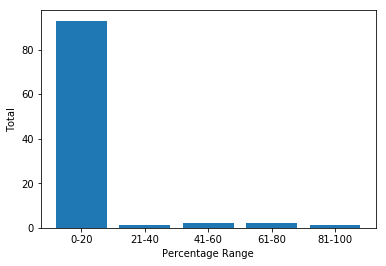

In [19]:
#visualise the output
plt.bar(missing_proportion_precentage.keys(), missing_proportion_precentage.values())
plt.xlabel('Percentage Range')
plt.ylabel('Total')
plt.show()

In [20]:
drop_list = proportion_missing_per_col_25.index.tolist() #list of columns with 25% or more missing values

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_list = proportion_missing_per_col_25.index.tolist()
drop_list

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [22]:
azdias_drop_25 = azdias.drop(drop_list, axis=1)

In [23]:
azdias_drop_25.shape

(891221, 79)

In [24]:
#a new table containing the top columns with the highest number of missing values
top_missing = feat_info[feat_info['attribute'].isin(drop_list)] 

In [25]:
#drop 'type' and 'missing_or_unknown' columns as they wont be useful in the analysis that follows
top_missing_drop = top_missing.drop(['type', 'missing_or_unknown'], axis=1)

In [26]:
top_missing_drop

,attribute,information_level
0,AGER_TYP,person
11,GEBURTSJAHR,person
40,TITEL_KZ,person
43,ALTER_HH,household
47,KK_KUNDENTYP,household
64,KBA05_BAUMAX,microcell_rr3


In [27]:
#merge the proportion_missing_per_col_25 with the top_missing_drop table to create a singular view of both information
top_missing_merged = pd.merge(top_missing_drop, pd.DataFrame(proportion_missing_per_col_25), 
                              right_index=True, left_on='attribute')

In [28]:
top_missing_merged.rename(columns={0: 'missing_proportion'}, inplace=True) 

In [29]:
top_missing_merged

,attribute,information_level,missing_proportion
0,AGER_TYP,person,0.769554
11,GEBURTSJAHR,person,0.440203
40,TITEL_KZ,person,0.997576
43,ALTER_HH,household,0.348137
47,KK_KUNDENTYP,household,0.655967
64,KBA05_BAUMAX,microcell_rr3,0.534687


In [30]:
top_missing_merged.sort_values(by='missing_proportion', ascending=False)

,attribute,information_level,missing_proportion
40,TITEL_KZ,person,0.997576
0,AGER_TYP,person,0.769554
47,KK_KUNDENTYP,household,0.655967
64,KBA05_BAUMAX,microcell_rr3,0.534687
11,GEBURTSJAHR,person,0.440203
43,ALTER_HH,household,0.348137


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- The pattern of missing data is understandable. TITEL_KZ (Academic title flag) is missing more than 99% of data, this could be a factual representation of the general population. According to World Bank, the total percentage of people with Doctoral degree in germany was about 1.253 % in 2018. 

- given the way the data was gathered (using public sources), its could be difficult to have a get an accurate academic qualification of individuals. 

- other information such as AGER_TYP(Best-ager typology), KBA05_BAUMAX(Most common building type within the microcell) would also be difficult to gatehr from online sources expecially if adresses aren't readily available. 


- 6 columns 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX' where dropped from the dataset as they had more than 25% missing values. 

- from the analysis above, about 92% of our data has less than 20% missing values, with about 8% going above 25% missing values

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

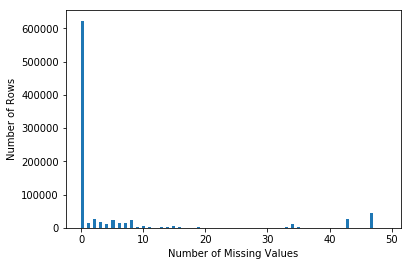

In [31]:
# How much data is missing in each row of the dataset?
# azdias_drop_25.isnull().sum(axis=1)
plt.hist(azdias_drop_25.isnull().sum(axis=1), bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [32]:
azdias_drop_25.isnull().sum(axis=1).value_counts()

0     623209
47     45578
2      27926
43     27369
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
34     10816
10      5410
15      4743
35      3911
13      3255
9       3042
33      2985
16      2505
14      2243
19      1180
11      1127
12       766
17       677
37       538
45       494
18       428
38       421
41       356
20       349
32       206
44       155
21       150
40       137
23       132
22       129
36        84
39        77
24        69
26        59
25        55
27        24
42        21
29        12
30         6
28         5
31         3
49         2
48         1
dtype: int64

In [33]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_less_20 = azdias_drop_25[azdias_drop_25.isnull().sum(axis=1)<=20]
azdias_more_20 = azdias_drop_25[azdias_drop_25.isnull().sum(axis=1)>20]

In [34]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def multi_plot(data1, data2, num_cols):
    """Creates a 2 columns multi rows plot of selected columns from the 2 input dataframes.
    data1: dataframe 
    data2: dataframe
    num_cols: number of columns to plot
    """
    
    random_columns = np.random.choice(data1.columns, size=num_cols, replace=False)
    
    figure, axs = plt.subplots(nrows=len(random_columns), ncols=2, figsize = (15,20))
    figure.subplots_adjust(hspace = 1, wspace=.3)
    for i in range(len(random_columns)):
        sns.countplot(data1[random_columns[i]], ax=axs[i][0])
        axs[i][0].set_title('Few or no missing values')
        sns.countplot(data2[random_columns[i]], ax=axs[i][1])
        axs[i][1].set_title('Many missing values')

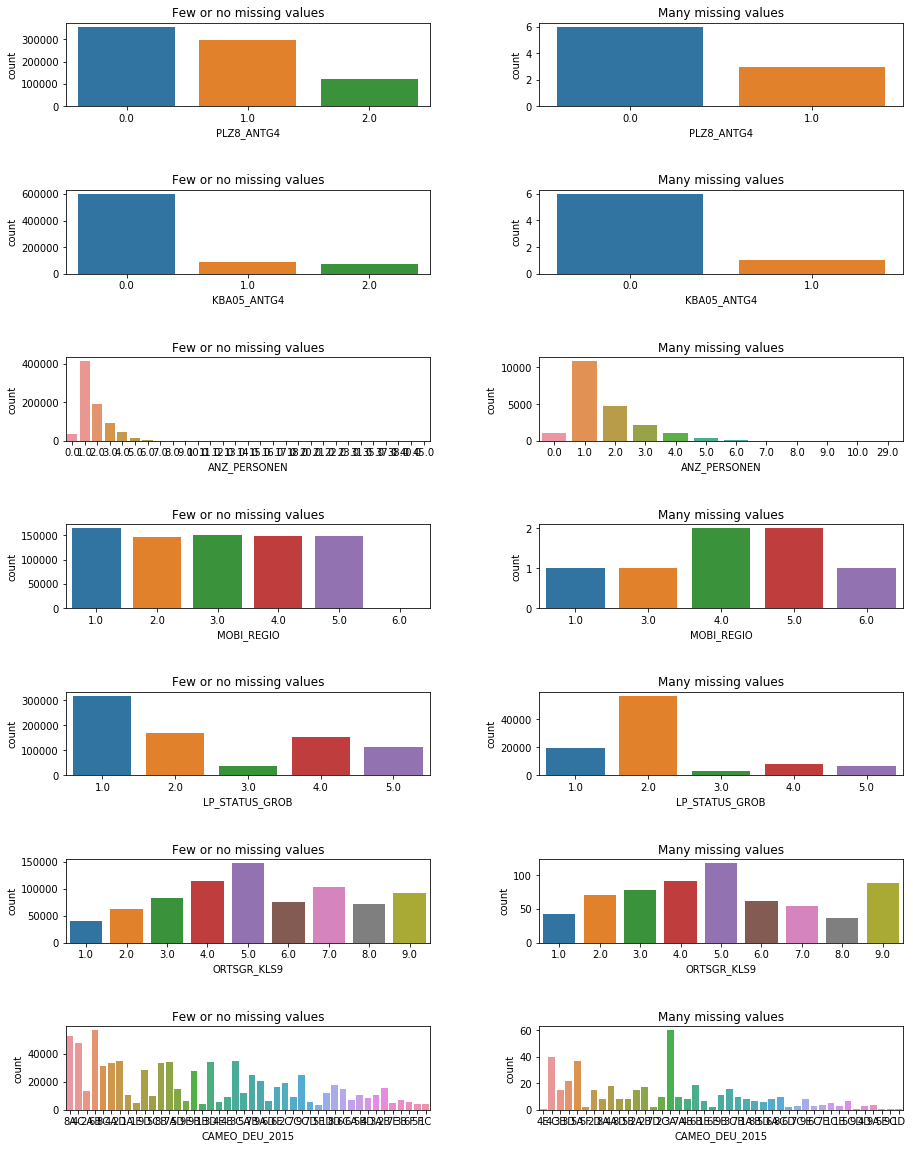

In [35]:
multi_plot(azdias_less_20, azdias_more_20, 7)

#### Discussion 1.1.3: Assess Missing Data in Each Row

In some cases, data with large amount of missing values are quantitatively different from their counterparts with less or zero missing values. As can be seen above, the distribution varies significantly between both groups. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
#get the index of the columns droped from the azdiaz dataframe as they will need to be dropped from the feat_info dataframe 
#as well
feat_info_drop_list = feat_info.loc[feat_info['attribute'].isin(drop_list)].index

In [37]:
feat_info_drop = feat_info.drop(feat_info_drop_list)

In [38]:
# How many features are there of each data type?
feat_info_drop.groupby(['type']).count()['attribute']

type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: attribute, dtype: int64

In [39]:
feat_info_drop.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = feat_info_drop[feat_info.type=='categorical']['attribute']

C:\Users\obinna\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
cat_features

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [42]:
binary_feature = []
multi_level_feature=[]

for column in cat_features:
    if azdias_drop_25[column].nunique() == 2:
        binary_feature.append(column)
    else:
        multi_level_feature.append(column)

In [43]:
print(f'columns with binary features: {binary_feature}')
print(f'columns with multi features: {multi_level_feature}')

columns with binary features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
columns with multi features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [44]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_drop_25.OST_WEST_KZ = azdias_drop_25.OST_WEST_KZ.map({ "W":0, "O":1})

In [45]:
# create a new DF of columns with multi-features
azdias_25_multi = azdias_drop_25[multi_level_feature]

In [46]:
# perform one-hot encoding on columns with multi-features
azdias_25_multi_dummies = pd.get_dummies(azdias_25_multi)

In [47]:
azdias_25_multi_dummies.head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.0,4,10.0,2.0,2.0,1.0,1.0,NaN,NaN,3,...,0,0,0,0,0,0,0,0,0,0
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,...,0,0,0,0,0,0,0,0,0,0
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,...,0,0,0,0,0,0,0,0,0,0
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# drop columns with multi features from DF
azdias_drop_25.drop(multi_level_feature, axis=1, inplace=True)

In [49]:
azdias_drop_25.shape

(891221, 66)

In [50]:
# Concat one-hot encoded multi-feature columns with the main DF
azdias_final = pd.concat([azdias_drop_25,azdias_25_multi_dummies], axis=1)

In [51]:
azdias_final.shape

(891221, 130)

In [52]:
feat_info.loc[feat_info['attribute'].isin(multi_level_feature)][['attribute', 'information_level']]

,attribute,information_level
3,CJT_GESAMTTYP,person
10,FINANZTYP,person
12,GFK_URLAUBERTYP,person
17,LP_FAMILIE_FEIN,person
18,LP_FAMILIE_GROB,person
19,LP_STATUS_FEIN,person
20,LP_STATUS_GROB,person
21,NATIONALITAET_KZ,person
38,SHOPPER_TYP,person
42,ZABEOTYP,person


#### Discussion 1.2.1: Re-Encode Categorical Features

I made the decision to keep all the features as i found that almost all of the categorical data fell under 'person' in the information_level. Given that they mostly fell under person, i made the assumption that they might contain useful information that could lead to better result, and simply dropping them might not be the best line of action. 

I used panda's get_dummmies method to perform the one-hot encoding on all categorical data with more than 2 levels. Those with 2 levels where left untouched except for 'OST_WEST_KZ' which i mapped to '1' and '0'.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [53]:
mixed_feat = feat_info_drop[feat_info.type=='mixed']['attribute']

C:\Users\obinna\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [54]:
list(mixed_feat)

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [55]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_final['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [56]:
#create a dictionary map for DECADE and MOVEMENT columns
decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_map = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [57]:
azdias_final['DECADE'] = azdias_final['PRAEGENDE_JUGENDJAHRE'] # Create a new column 'DECADE'

In [58]:
azdias_final.DECADE = azdias_final.DECADE.map(decade_map) # Map column to new values'

In [59]:
azdias_final['MOVEMENT'] = azdias_final['PRAEGENDE_JUGENDJAHRE'] # Create a new column 'MOVEMENT'

In [60]:
azdias_final.MOVEMENT = azdias_final.MOVEMENT.map(movement_map) # Map column to new values'

In [61]:
azdias_final[['PRAEGENDE_JUGENDJAHRE','MOVEMENT','DECADE']].head(10)

,PRAEGENDE_JUGENDJAHRE,MOVEMENT,DECADE
0,NaN,NaN,NaN
1,14.0,1.0,6.0
2,15.0,0.0,6.0
3,8.0,1.0,4.0
4,8.0,1.0,4.0
5,3.0,1.0,2.0
6,10.0,1.0,5.0
7,8.0,1.0,4.0
8,11.0,0.0,5.0
9,15.0,0.0,6.0


In [62]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#create a dictionary map for WEALTH and LIFE_STAGE columns
wealth_map = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_map = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [63]:
azdias_final['WEALTH'] = azdias_final.CAMEO_INTL_2015 # Create a new column 'WEALTH'
azdias_final['LIFE_STAGE'] = azdias_final.CAMEO_INTL_2015 # Create a new column 'LIFE_STAGE'

In [64]:
azdias_final.WEALTH = azdias_final.WEALTH.map(wealth_map) # Map column to new values'
azdias_final.LIFE_STAGE = azdias_final.LIFE_STAGE.map(life_stage_map) # Map column to new values'

In [65]:
azdias_final[['CAMEO_INTL_2015','WEALTH','LIFE_STAGE']].head(10)

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
0,NaN,NaN,NaN
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0
6,22,2.0,2.0
7,14,1.0,4.0
8,13,1.0,3.0
9,15,1.0,5.0


In [66]:
azdias_final[mixed_feat].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
0,15.0,4.0,NaN,NaN,NaN,NaN
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
3,NaN,NaN,8.0,7.0,12,1.0
4,32.0,10.0,8.0,3.0,43,2.0


In [67]:
azdias_final.drop(mixed_feat, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features
Four new columns were created from the 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' mixed columns. An all mixed features droped

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [68]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [69]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [70]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for idx in range(feat_info.shape[0]):

        missing_or_unknown = feat_info.iloc[idx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[]')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(i) if (i!='X' and i!='XX' and i!='') else i for i in missing_or_unknown]
        if missing_or_unknown != ['']:
            df.iloc[:,idx] = df.iloc[:,idx].replace(missing_or_unknown, np.nan)
    
    #encode OST_WEST_KZ
    df.OST_WEST_KZ = df.OST_WEST_KZ.map({ "W":0, "O":1})
    
    # remove selected columns and rows, ...
    #create a drop list based on previous analysis
    drop_columns_list = ['AGER_TYP',  'GEBURTSJAHR', 'TITEL_KZ',  'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    
    df.drop(drop_columns_list, axis=1, inplace=True)
    
    cat_features = feat_info_drop[feat_info.type=='categorical']['attribute']

    multi_level_feature=[]

    for column in cat_features:
        if df[column].nunique() > 2:
            multi_level_feature.append(column)           

    df_multi = df[multi_level_feature]
    df_multi_dummies = pd.get_dummies(df_multi)
    df.drop(multi_level_feature, axis=1, inplace=True)

    df = pd.concat([df,df_multi_dummies], axis=1)
    
    mixed_feat = feat_info_drop[feat_info.type=='mixed']['attribute']
    
    #create a dictionary map for DECADE and MOVEMENT columns
    decade_map = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_map = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'] # Create a new column 'DECADE'
    df.DECADE = df.DECADE.map(decade_map) # Map column to new values'
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'] # Create a new column 'MOVEMENT'
    df.MOVEMENT = df.MOVEMENT.map(movement_map) # Map column to new values'

    #create a dictionary map for WEALTH and LIFE_STAGE columns
    wealth_map = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_map = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}

    df['WEALTH'] = df.CAMEO_INTL_2015 # Create a new column 'WEALTH'
    df['LIFE_STAGE'] = df.CAMEO_INTL_2015 # Create a new column 'LIFE_STAGE'

    df.WEALTH = df.WEALTH.map(wealth_map) # Map column to new values'
    df.LIFE_STAGE = df.LIFE_STAGE.map(life_stage_map) # Map column to new values'	

    df.drop(mixed_feat, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [71]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_final.isnull().sum()

ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                   73499
VERS_TYP                 111196
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
                          ...  
CAMEO_DE

In [72]:
imputer = Imputer(strategy='most_frequent')

In [73]:
azdias_impute = pd.DataFrame(imputer.fit_transform(azdias_final))

In [74]:
azdias_impute.isnull().sum().sum()

0

In [75]:
azdias_impute.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,1.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,4.0,3.0


In [76]:
azdias_impute.columns = azdias_final.columns

In [77]:
azdias_impute.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,1.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,4.0,3.0


In [78]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

In [79]:
azdias_scaled = scaler.fit_transform(azdias_impute)

In [80]:
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_impute.columns)

In [81]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,0.494701,1.039938,-1.095866
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,0.494701,1.039938,-1.095866
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,-2.021423,-0.980453,0.879581
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.363493,0.494701,-1.653917,-0.437384
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.363493,0.494701,0.366474,0.221098


### Discussion 2.1: Apply Feature Scaling

'most frequent' strategy was used for for filling NAN values. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [82]:
# Apply PCA to the data.
pca = PCA()

In [83]:
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

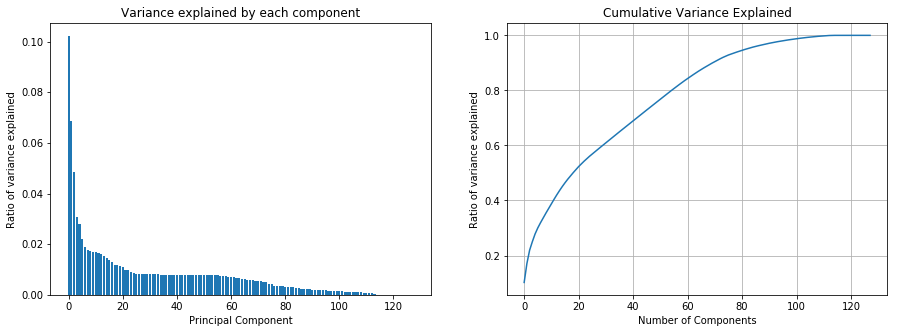

In [84]:
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
# figure.subplots_adjust(hspace = 1, wspace=.3)

plt.subplot(1,2,1)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal Component")
plt.ylabel("Ratio of variance explained")

plt.subplot(1,2,2)
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.grid()

plt.show()

In [85]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_80 = PCA(n_components=80)
azdias_pca = pca_80.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

I chose to retain 80 components as this accounts for over 90% of the variability in the data while reducing the number of features by about 37 percent

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [86]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=azdias_scaled.columns)
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [87]:
pca_w1 = pca_weights(pca_80, 0)
print(pca_w1.head(10).append(pca_w1.tail(10)))

WEALTH                0.203075
PLZ8_ANTG3            0.200379
EWDICHTE              0.169471
PLZ8_ANTG4            0.165140
ORTSGR_KLS9           0.162525
HH_EINKOMMEN_SCORE    0.157000
FINANZ_HAUSBAUER      0.151089
PLZ8_ANTG2            0.138410
ARBEIT                0.131143
FINANZ_SPARER         0.129754
INNENSTADT           -0.132204
PLZ8_GBZ             -0.146687
KONSUMNAEHE          -0.151744
KBA05_GBZ            -0.194918
KBA05_ANTG1          -0.198343
FINANZ_MINIMALIST    -0.199578
PLZ8_ANTG1           -0.200284
MOBI_REGIO           -0.203902
LP_STATUS_FEIN       -0.211695
LP_STATUS_GROB       -0.213948
Name: 0, dtype: float64


In [88]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_w2 = pca_weights(pca_80, 1)
print(pca_w2.head(10).append(pca_w2.tail(10)))

ALTERSKATEGORIE_GROB     0.258238
FINANZ_VORSORGER         0.237174
SEMIO_ERL                0.213189
SEMIO_LUST               0.172781
RETOURTYP_BK_S           0.166668
FINANZTYP                0.115318
FINANZ_HAUSBAUER         0.108626
SHOPPER_TYP              0.103575
PLZ8_ANTG4               0.102035
W_KEIT_KIND_HH           0.096749
SEMIO_FAM               -0.165474
SEMIO_KULT              -0.170380
SEMIO_RAT               -0.187637
SEMIO_TRADV             -0.218113
FINANZ_ANLEGER          -0.226067
SEMIO_PFLICHT           -0.235440
FINANZ_UNAUFFAELLIGER   -0.240467
SEMIO_REL               -0.246704
FINANZ_SPARER           -0.249439
DECADE                  -0.254179
Name: 1, dtype: float64


In [89]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_w3 = pca_weights(pca_80, 2)
print(pca_w3.head(10).append(pca_w3.tail(10)))

SEMIO_VERT               0.341824
SEMIO_SOZ                0.294426
SEMIO_KULT               0.292248
SEMIO_FAM                0.227897
PLZ8_ANTG4               0.095811
FINANZ_MINIMALIST        0.091555
SEMIO_MAT                0.078911
FINANZTYP                0.075140
SEMIO_REL                0.067685
ORTSGR_KLS9              0.061275
FINANZ_UNAUFFAELLIGER   -0.092417
KBA13_ANZAHL_PKW        -0.102900
SHOPPER_TYP             -0.109560
SEMIO_RAT               -0.139458
FINANZ_ANLEGER          -0.158288
SEMIO_ERL               -0.184110
SEMIO_KRIT              -0.310518
SEMIO_DOM               -0.315270
ANREDE_KZ               -0.335888
SEMIO_KAEM              -0.344236
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

Looking at the 3 principal components aboe, one can deduce that PLZ8_ANTG4(Number of 10+ family houses in the PLZ8 region) and FINANZ(financial topology) tend to have a positive correlation.  

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [90]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score
    

Text(0.5,1,'SSE vs. K')

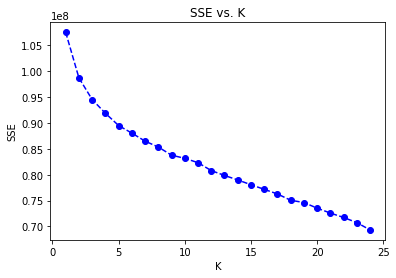

In [91]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,25))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [110]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 11)
kmeans_11 = kmeans.fit(azdias_pca)
azdias_pred = kmeans_11.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Looks like the elbow falls at K=11. I will therefore be using 11 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [93]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [94]:
customers_processed = clean_data(customers)

C:\Users\obinna\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\obinna\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


In [95]:
#Impute missing values
customers_imputed = pd.DataFrame(imputer.transform(customers_processed))

In [96]:
customers_imputed.isnull().sum().sum()

0

In [97]:
customers_imputed.columns = customers_processed.columns

In [98]:
#Scale customer data
customers_scaled = scaler.transform(customers_imputed)

In [99]:
customers_scaled = pd.DataFrame(customers_scaled, columns=customers_imputed.columns)

In [100]:
customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,-0.587980,-0.794475,2.021423,-1.708990,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-1.721978,-2.021423,-1.653917,0.221098
1,1.23164,-1.045218,1.457527,-1.243244,1.209329,-1.329319,0.084637,-0.794475,-0.494701,-1.708990,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.994991,0.494701,1.039938,-1.095866
2,1.23164,0.956738,1.457527,-1.243244,1.209329,-1.329319,0.757254,0.683452,2.021423,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-1.721978,-2.021423,-0.306989,0.879581
3,1.23164,-1.045218,1.457527,-1.243244,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-2.401220,0.494701,-0.980453,0.879581
4,0.23998,-1.045218,-0.056416,-1.243244,0.452976,0.631976,1.429871,-0.794475,-0.494701,0.938197,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-0.363493,0.494701,0.366474,-1.095866


In [101]:
#PCA tranform customer data
customers_pca = pca_80.transform(customers_scaled)

In [111]:
customers_predict = kmeans_11.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

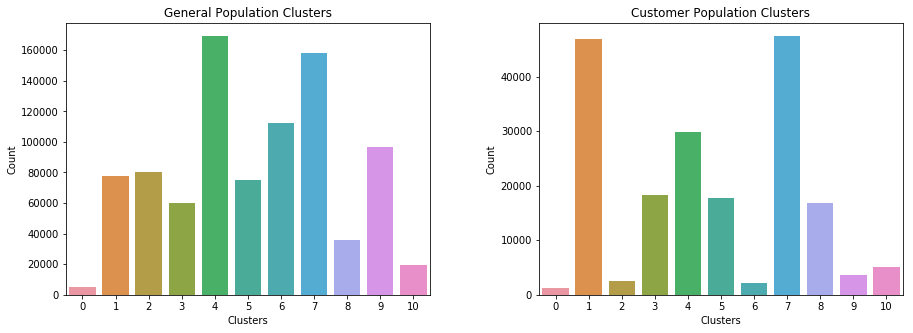

In [112]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

plt.subplot(1,2,1)
sns.countplot(azdias_pred)
plt.title("General Population Clusters")
plt.xlabel("Clusters")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.countplot(customers_predict)
plt.title("Customer Population Clusters")
plt.xlabel("Clusters")
plt.ylabel("Count")
# plt.grid()

plt.show()

In [156]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

center_1 = scaler.inverse_transform(pca_80.inverse_transform(kmeans_11.cluster_centers_[1]))

In [157]:
over_rep_customer = pd.Series(center_1, index=customers_processed.columns)

In [158]:
over_rep_customer.sort_values(ascending=False)

MIN_GEBAEUDEJAHR         1.992014e+03
KBA13_ANZAHL_PKW         1.398108e+03
WOHNDAUER_2008           8.950735e+00
SEMIO_KRIT               7.035729e+00
SEMIO_REL                6.725684e+00
W_KEIT_KIND_HH           6.141911e+00
BALLRAUM                 6.084742e+00
GFK_URLAUBERTYP          6.031914e+00
EWDICHTE                 6.030256e+00
REGIOTYP                 6.022298e+00
DECADE                   5.987577e+00
SEMIO_DOM                5.957100e+00
SEMIO_KAEM               5.956307e+00
SEMIO_FAM                5.790163e+00
ORTSGR_KLS9              5.072048e+00
SEMIO_PFLICHT            5.066648e+00
CJT_GESAMTTYP            5.046302e+00
SEMIO_MAT                5.015050e+00
INNENSTADT               4.974434e+00
FINANZ_ANLEGER           4.973783e+00
WEALTH                   4.941294e+00
FINANZ_UNAUFFAELLIGER    4.937177e+00
SEMIO_LUST               4.884658e+00
LP_STATUS_FEIN           4.861049e+00
SEMIO_RAT                4.070528e+00
GEBAEUDETYP_RASTER       4.021654e+00
ARBEIT      

In [159]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
center_6 = scaler.inverse_transform(pca_80.inverse_transform(kmeans_11.cluster_centers_[6]))
under_rep_customer = pd.Series(center_6, index=customers_processed.columns)

In [160]:
under_rep_customer.sort_values(ascending=False)

MIN_GEBAEUDEJAHR         1993.017193
KBA13_ANZAHL_PKW          650.365057
ANZ_HAUSHALTE_AKTIV         8.578002
GFK_URLAUBERTYP             8.498430
WOHNDAUER_2008              7.289369
SEMIO_DOM                   6.089633
SEMIO_RAT                   6.054179
SEMIO_PFLICHT               5.980405
SEMIO_KAEM                  5.924642
DECADE                      5.712992
ORTSGR_KLS9                 5.588386
SEMIO_TRADV                 5.553601
SEMIO_KRIT                  5.538370
SEMIO_REL                   5.225378
HH_EINKOMMEN_SCORE          5.124980
SEMIO_MAT                   4.880981
REGIOTYP                    4.712279
SEMIO_ERL                   4.380217
INNENSTADT                  4.366368
FINANZ_ANLEGER              4.295951
ZABEOTYP                    4.274308
EWDICHTE                    4.243713
FINANZ_SPARER               4.209375
CJT_GESAMTTYP               4.058103
BALLRAUM                    4.056587
SEMIO_KULT                  3.949239
FINANZ_UNAUFFAELLIGER       3.939770
W

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 1 is over-represented in the customer data while cluster 6 is under-represented. 

for the over-represented cluster 1, factors such as GFK_URLAUBERTYP(vacation habit), EWDICHTE(Density of households per square kilometer), WEALTH among others features in the top deciding factors for this cluster. 

While SEMIO(personality topology), ORTSGR_KLS9(size of community) are some of the main deciding factors for the under-represented cluster. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.